In [25]:
# Data visualization
import matplotlib.pyplot as plt

# Data manipulation
import pandas as pd
import numpy as np

import glob, re, os, sys, random
from random import shuffle
import random
from time import time

# Vector representations and embeddings
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gensim

# Modeling - Logistic, XGBOOST, SVM
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, roc_auc_score

from sklearn.pipeline import Pipeline, FeatureUnion

from xgboost import XGBClassifier
import pickle


In [26]:
import sys
sys.path.append(f'../../python')
from grid_search import create_label, balance_unique_id, \
create_balanced_excluded, create_train_test_excluded, group_by_case, \
create_feature_label, gridsearch, fit_best_model_train, evaluate, fit_best_model_test, \
train_model_cross_val, train_model_test, \
get_feature_importance_cv, get_feature_importance, get_feature_importance10

### Load data

In [68]:
df = pd.read_json(r"../../../data/processed/pre-processed_2023_03_20.json")

### Balance data and split to train and test set

In [69]:
label_name = "phase2"

In [70]:
df1 = create_label(df, label_name)
df_unique = balance_unique_id(df1)
df_balanced_unique, df_balanced, df_excluded = create_balanced_excluded(df_unique, df1)
df_train, df_test, df_test1 = create_train_test_excluded(df_balanced, df_balanced_unique, df_excluded)
df_train_grouped, df_test_grouped, df_test1_grouped, df_excluded_grouped = group_by_case(df_train, df_test, df_test1, df_excluded)

Total decisions: 1583
0    1485
1      98
Name: label, dtype: int64
Balancing...
Total decisions: 196
Labels distribution: 
 0    98
1    98
Name: 0, dtype: int64
Training set shape: (157,) (157,)
Test set shape: (40,) (40,)
Creating df_train 1: 78 0: 79
Creating df_test1 1: 20 0: 20
Creating df_test concatenated with df_excluded with len: 1386
Creating df_test 1: 20 0: 1406
Grouping df_train by case_num 1: 78 0: 79
Grouping df_test by case_num 1: 20 0: 1406
Grouping df_test1 by case_num 1: 20 0: 20
Grouping df_excluded by case_num with len: 1386


In [71]:
X_train, y_train, X_test, y_test, X_test1, y_test1, X_test2, y_test2 = create_feature_label(df_train_grouped, df_test_grouped, df_test1_grouped, df_excluded_grouped)

### Hyperparameter tuning with GridSearch Cross Validation

In [8]:
# Define model
model = LinearSVC()

# Create a pipeline with TfidfVectorizer and Model
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer='word', max_features=5000, stop_words='english')),
    ('clf', model)

])

# Define the grid of hyperparameters to search over
parameters = {
    'tfidf__ngram_range': [(2,2),(2,3), (2,4), (3,3), (3,4)], #(1,2),(1,1),(1,3),
    #'tfidf__analyzer': ('word', 'char'),
    #'tfidf__lowercase': (True, False),
    'tfidf__max_df': [0.01, 0.025, 0.05], # (0.01, 1.0), # ignore words that occur as more than x% of corpus
    # 'tfidf__min_df': (1, 2, 3), # we need to see a word at least (once, twice, thrice) in a document
    'tfidf__use_idf': (False, True), # use inverse document frequency weighting
    #'tfidf__sublinear_tf': (False, True),
    'tfidf__binary': (False, True), #set term frequency binary (all non-zero terms are set to 1)
    'tfidf__norm': ('l1', 'l2'), #norm used to normalize term vectors
    # 'tfidf__max_features': (None, 2000, 5000),
    #'tfidf__stop_words': (None, 'english'),

    # 'clf__solver': ['liblinear', 'lbfgs'],
    'clf__C':(0.1, 1, 5) # penalty parameter for the model
}

In [9]:
grid_search, best_parameters = gridsearch(pipeline, parameters, X_train, y_train, cv=3, scoring='roc_auc')

Fitting 3 folds for each of 360 candidates, totalling 1080 fits
done in 1889.570s
Best cross-validation score:  0.8872527472527473
Best parameters set:
	clf__C: 5
	tfidf__binary: True
	tfidf__max_df: 0.05
	tfidf__ngram_range: (2, 4)
	tfidf__norm: 'l2'
	tfidf__use_idf: False


##### Model fitting and evaluation

In [10]:
pipeline_cv, y_predict_cv = fit_best_model_train(X_train, y_train, model, best_parameters, cv=3)

fitting the best model
Accuracy: 0.89171974522293

Classification report:
               precision    recall  f1-score   support

           0       0.87      0.92      0.90        79
           1       0.92      0.86      0.89        78

    accuracy                           0.89       157
   macro avg       0.89      0.89      0.89       157
weighted avg       0.89      0.89      0.89       157


CR: (0.8934279191128507, 0.8915124959428757, 0.8915613700077195, None)

Confusion matrix:
 [[73  6]
 [11 67]] 

_______________________


 Accuracy: 89.17 
 Precision: 0.918 
 Recall: 0.859 
 F1: 0.887


Saving the features and coefficients into a dataframe determined by gridsearchCV best_parameters.

In [11]:
df_features_cv = get_feature_importance_cv(pipeline_cv)
df_features_cv.to_excel('../../../output/tables/features_svm_cv_full_p2.xlsx', index=True)
df_features_cv.head()

,feature,importance
512,china india,0.755641
4450,spain germany,0.607744
4193,segmentation based type,-0.557414
104,advisory committee concentration,0.533968
647,committee concentration,0.533968


In [12]:
y_predict_cv_test = fit_best_model_test(X_test, y_test, pipeline_cv)

testing on test set
Accuracy: 0.9244226731980406

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.92      0.96      1409
           1       0.15      0.90      0.25        20

    accuracy                           0.92      1429
   macro avg       0.57      0.91      0.61      1429
weighted avg       0.99      0.92      0.95      1429


CR: (0.5718143616363861, 0.9123846699787084, 0.6051031687546058, None)

Confusion matrix:
 [[1303  106]
 [   2   18]] 

_______________________


 Accuracy: 92.44 
 Precision: 0.145 
 Recall: 0.900 
 F1: 0.250


In [13]:
y_predict_cv_test = fit_best_model_test(X_test1, y_test1, pipeline_cv)

testing on test set
Accuracy: 0.925

Classification report:
               precision    recall  f1-score   support

           0       0.90      0.95      0.93        20
           1       0.95      0.90      0.92        20

    accuracy                           0.93        40
   macro avg       0.93      0.93      0.92        40
weighted avg       0.93      0.93      0.92        40


CR: (0.9260651629072681, 0.925, 0.924953095684803, None)

Confusion matrix:
 [[19  1]
 [ 2 18]] 

_______________________


 Accuracy: 92.50 
 Precision: 0.947 
 Recall: 0.900 
 F1: 0.923


### Model training (with 10-fold CV) using best parameters from GridSearch

In [75]:
for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

	clf__C: 5
	tfidf__binary: True
	tfidf__max_df: 0.05
	tfidf__ngram_range: (2, 4)
	tfidf__norm: 'l2'
	tfidf__use_idf: False


In [76]:
vec = ('wordvec', TfidfVectorizer(analyzer = 'word', max_features=5000, stop_words='english', ngram_range = (2,4), binary = True, max_df = 0.05, norm = 'l2', use_idf = False))
c = 5
# solver = 'liblinear'
model=LinearSVC(C=c)

In [77]:
pipeline_train, trained_model, y_predict_train = train_model_cross_val(X_train, y_train, vec=vec, model=model, cv=10)

***10-fold cross-validation***
Accuracy: 0.8726114649681529

Classification report:
               precision    recall  f1-score   support

           0       0.87      0.87      0.87        79
           1       0.87      0.87      0.87        78

    accuracy                           0.87       157
   macro avg       0.87      0.87      0.87       157
weighted avg       0.87      0.87      0.87       157


CR: (0.8726062966569296, 0.8726062966569296, 0.8726062966569296, None)

Confusion matrix:
 [[69 10]
 [10 68]] 

_______________________


 Accuracy: 87.26 
 Precision: 0.872 
 Recall: 0.872 
 F1: 0.872


In [102]:
evaluate(y_train, y_predict_train)

Accuracy: 0.8726114649681529

Classification report:
               precision    recall  f1-score   support

           0       0.87      0.87      0.87        79
           1       0.87      0.87      0.87        78

    accuracy                           0.87       157
   macro avg       0.87      0.87      0.87       157
weighted avg       0.87      0.87      0.87       157


CR: (0.8726062966569296, 0.8726062966569296, 0.8726062966569296, None)

Confusion matrix:
 [[69 10]
 [10 68]] 

_______________________


 Accuracy: 87.261 
 Precision: 0.872 
 Recall: 0.872 
 F1: 0.872 
 FPR: 0.127


In [78]:
pipeline_test, y_predict_test = train_model_test(X_train, y_train, X_test, y_test, model=model, vec=vec)

***testing on test set***
Accuracy: 0.9530154277699859

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98      1406
           1       0.20      0.80      0.32        20

    accuracy                           0.95      1426
   macro avg       0.60      0.88      0.65      1426
weighted avg       0.99      0.95      0.97      1426


CR: (0.5997810417900069, 0.8775960170697013, 0.6494476182089695, None)

Confusion matrix:
 [[1343   63]
 [   4   16]] 

_______________________


 Accuracy: 95.30 
 Precision: 0.203 
 Recall: 0.800 
 F1: 0.323


In [79]:
pipeline_test1, y_predict_test1 = train_model_test(X_train, y_train, X_test1, y_test1, model=model, vec=vec)

***testing on test set***
Accuracy: 0.875

Classification report:
               precision    recall  f1-score   support

           0       0.83      0.95      0.88        20
           1       0.94      0.80      0.86        20

    accuracy                           0.88        40
   macro avg       0.88      0.88      0.87        40
weighted avg       0.88      0.88      0.87        40


CR: (0.8836317135549872, 0.875, 0.8742928975487115, None)

Confusion matrix:
 [[19  1]
 [ 4 16]] 

_______________________


 Accuracy: 87.50 
 Precision: 0.941 
 Recall: 0.800 
 F1: 0.865


### Confusion matrix and model performance

In [96]:
print(df_test_grouped['case_num'].nunique())
print(len(X_test))
print(len(df_test_grouped))

1426
1426
1426


In [83]:
results_test = pd.DataFrame(np.column_stack((X_test, y_test, y_predict_test)), columns=['text', 'target', 'y_predict'])
results_test = pd.concat([df_test_grouped, results_test], axis=1)

In [84]:
tn=results_test[(results_test.target == 0) & (results_test.y_predict == 0)]
fp=results_test[(results_test.target == 0) & (results_test.y_predict == 1)]
fn=results_test[(results_test.target == 1) & (results_test.y_predict == 0)]
tp=results_test[(results_test.target == 1) & (results_test.y_predict == 1)]

print("TN:", len(tn))
print("FP:", len(fp))

print("FN:", len(fn))
print("TP:", len(tp))

TN: 1343
FP: 63
FN: 4
TP: 16


In [94]:
fp['article_new'].value_counts()

article6(1)(b)    43
article6(2)       20
Name: article_new, dtype: int64

In [95]:
fp['text']

33      marketing communication service methodology pa...
83      relevant market relevant product market brande...
141     horizontal effect party substantial market sha...
250     relevant product market proposed concentration...
255     proposed transaction lead limited horizontal o...
                              ...                        
1391    analytical framework article merger regulation...
1399    identification affected market horizontally af...
1420    analytical framework article merger regulation...
1422    legal framework party concentration actual pot...
1424    salmar nt active market farming primary proces...
Name: text, Length: 63, dtype: object

### Feature importance

In [19]:
df_features_train, feature_importance, feature_names = get_feature_importance(trained_model, pipeline_train)
df_features_train.head(10)

,feature,importance,abs_importance
512,china india,0.755638,0.755638
4450,spain germany,0.607740,0.607740
4193,segmentation based type,-0.557413,0.557413
104,advisory committee concentration,0.533968,0.533968
647,committee concentration,0.533968,0.533968
2389,level example,0.519409,0.519409
3704,provide necessary,0.471807,0.471807
3515,previous decision commission distinguished,-0.463033,0.463033
1576,eur million target,-0.458490,0.458490
4025,result concentration meaning article,0.456084,0.456084


In [270]:
# df_features_train['abs_importance'] = abs(df_features_train['importance'])
# df_features_train = df_features_train.sort_values(by='abs_importance', ascending=False)
# df_features_train_top10 = df_features_train.nlargest(10, 'abs_importance') #importance

# fig, ax = plt.subplots(figsize=(8, 6))
# ax.barh(df_features_train_top10['feature'], df_features_train_top10['importance'], color='darkblue')
# ax.set_xlabel('Importance')
# ax.set_title('Top 10 Features by Importance')

# plt.show()


Get features for label = 1 and label = 0

In [20]:
df_features_train1, df_features_train0 = get_feature_importance10(df_features_train)

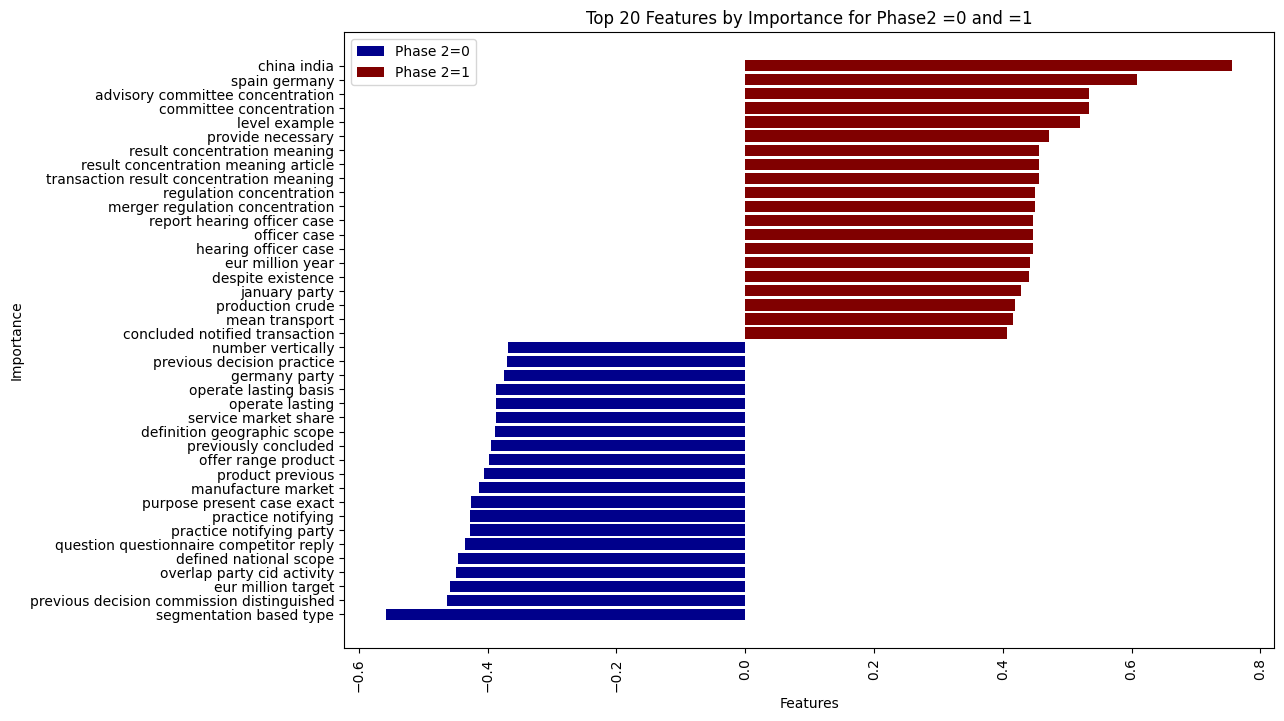

In [21]:
# Sort the features by absolute importance for label=1
df_features_train1 = df_features_train1.sort_values(by='abs_importance', ascending=False)
df_features_train1_top10 = df_features_train1.nlargest(20, 'abs_importance')
df_features_train1_top10 = df_features_train1_top10.sort_values('importance', ascending=True)

# Sort the features by absolute importance for label=0
df_features_train0 = df_features_train0.sort_values(by='abs_importance', ascending=False)
df_features_train0_top10 = df_features_train0.nlargest(20, 'abs_importance')

# Create a combined bar chart
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(df_features_train0_top10['feature'], df_features_train0_top10['importance'], color='darkblue', label='Phase 2=0')
ax.barh(df_features_train1_top10['feature'], df_features_train1_top10['importance'], color='maroon', label='Phase 2=1')
ax.set_xlabel('Features')
ax.set_ylabel('Importance')
ax.set_title('Top 20 Features by Importance for Phase2 =0 and =1')
ax.legend()
plt.xticks(rotation=90)
plt.show()

In [273]:
df_features_train.to_excel('../../../output/tables/features_svm_train_full_p2.xlsx', index=True)

In [33]:
y_predict_test1

array([1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1], dtype=int64)

In [34]:
X_train

0      undertaking concerned combined aggregate world...
1      party overlapping activity area party ’ combin...
2      borden bakelite active production sale amino r...
3      celanese acetex signed arrangement agreement p...
4      interventional cardiology drug eluting stent i...
                             ...                        
152    annex analysis party ’ opportunity data submit...
153    transaction union dimension meaning article me...
154    transaction give rise vertically affected mark...
155    proposed transaction give rise seven horizonta...
156    analytical framework legal test assessment hor...
Name: text_clean, Length: 157, dtype: object